In [1]:
import os, sys
import argparse
import time
from os.path import exists
import collections
from typing import Iterable
import pickle
from collections import Counter

import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_meta = pd.read_csv(f"meta_real_datasets.csv")

In [3]:
parent_folder = "output/benchmark"

In [4]:
import rpy2.robjects as robject
datasets = robject.r(r'''

setwd("./")
datasets <- list.files('all_data/real')
datasets''')

datasets = list(datasets)

# Load trajectory result

In [5]:
import h5py

In [7]:
_idx = 61

## load expression 

In [8]:
# load true 
filename = datasets[_idx]
project = filename.split('.')[0]
filepath = f"all_data/real/{filename}"

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
df = readRDS(filepath)
# df = pandas2ri.rpy2py_dataframe(df)
data_keys = list(df.names)

cell_ids = df[data_keys.index('cell_ids')]
expression = df[data_keys.index('expression')]  # log 2 transformed counts 
genes = df[data_keys.index('feature_info')]['feature_id'].values

N = len(cell_ids)
G = len(genes)
z_dim = 30

# expression all > 0, log() transformed? and before normalized? 
assert expression[np.where(expression < 0)].shape[0] == 0

# true trajectory
milestones_true = df[data_keys.index('milestone_ids')]
network_true = df[data_keys.index('milestone_network')]
# update parameters for the model 
M_true = len(milestones_true)

# add node index; node index consistent with index in 'milestone_ids'
# will use node index to present node from now on
network_true['idx_from'] = [list(milestones_true).index(i) for i in network_true['from']]
network_true['idx_to'] = [list(milestones_true).index(i) for i in network_true['to']]
edges_true = network_true[['idx_from','idx_to']].values
_nodes_no_to = list(set(range(M_true)) - set(edges_true[:, 1]))
# root_true = _nodes_no_to[0]

# TBD: group_ids different from milestone_ids? 

# assignment = df[_keys.index('cell_info')]  # only equal for ground truth membership ? 
membership_true = df[data_keys.index('milestone_percentages')] 
# from membership probability get assignment of cells to nodes
assignment_true = membership_true[membership_true.groupby(['cell_id'])['percentage'].transform(max) == membership_true['percentage']]
assignment_true.set_index('cell_id', inplace=True)
assignment_true = assignment_true.reindex(cell_ids)
clusters_true = [list(milestones_true).index(c) for c in assignment_true['milestone_id'].values]

## load estimated trajectory models

In [227]:
sub_models = ['ti_monocle3_reg', 'ti_slingshot_reg'] 

In [228]:
df_percentages = []
df_progressions = []
df_networks = []
df_clusters = []
_missing = []

In [229]:
for _idx in [_idx]:
    for _model in sub_models: 
        filename = f"output/benchmark/{_model}/output_{_idx}.h5"
        
        try:
            f = h5py.File(filename, 'r')

            # for key in f.keys():
            #     print(key) 

            key = 'data'

            #Get the HDF5 group
            group = f[key]

            # #Checkout what keys are inside that group.
            # for key in group.keys():
            #     print(key)

            _percentages = group['milestone_percentages']
            _network = group['milestone_network']
            _progressions = group['progressions']

            #  data.keys()
            #  data['data'].keys()
            cur_meta = data_meta.loc[_idx, :]
            print(f"{_idx}: real {cur_meta['n_milestones']}; {cur_meta['trajectory_type']}  {cur_meta['n_cells']}; {_model}: {len(set(list(_percentages['data']['milestone_id'])))}")

            _cell_ids = list(_percentages['data']['cell_id'])
            _cell_ids = [i.decode('utf-8') for i in _cell_ids]
            estimated_percentages = pd.DataFrame(zip(_cell_ids, list(_percentages['data']['milestone_id']), list(_percentages['data']['percentage'])))
            estimated_percentages.columns = ['cell_id', 'milestone_id', 'percentage']

            _cell_ids = list(_progressions['data']['cell_id'])
            _cell_ids = [i.decode('utf-8') for i in _cell_ids]
            estimated_progressions = pd.DataFrame(zip(_cell_ids, list(_progressions['data']['from']), list(_progressions['data']['to']), list(_progressions['data']['percentage'])))
            estimated_progressions.columns = ['cell_id', 'from', 'to' ,'percentage']

            estimated_network = pd.DataFrame(pd.DataFrame(zip(list(_network['data']['from']), list(_network['data']['to']), list(_network['data']['length']))))
            estimated_clusters = estimated_percentages.loc[estimated_percentages.groupby(["cell_id"])["percentage"].idxmax()].set_index('cell_id') .reindex(cell_ids)
            estimated_clusters['milestone_id'] = [_c.decode("utf-8") for _c in estimated_clusters['milestone_id']]

            df_percentages.append(estimated_percentages)
            df_progressions.append(estimated_progressions)
            df_networks.append(estimated_network)
            df_clusters.append(estimated_clusters)
        
        except OSError:
            print(_model)
            _missing.append(_model)
        

22: real 7; bifurcation  272; ti_monocle3_reg: 6
22: real 7; bifurcation  272; ti_slingshot_reg: 4


In [230]:
sub_models_fil = sub_models.copy()

In [231]:
for i in _missing:
    sub_models_fil.remove(i)

# Exploring results

In [232]:
# sub_metrics = metrics[metrics['data'] == _idx]

In [233]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder  

In [234]:
for i in range(len(df_percentages)):
    _model = sub_models_fil[i]
    
    estimated_clusters = df_clusters[i]
    clusters_estimated = estimated_clusters['milestone_id'].values
    le = LabelEncoder()
    clusters_estimated = le.fit_transform(clusters_estimated)

    _ari = adjusted_rand_score(clusters_true, clusters_estimated)
    _f1_score = f1_score(clusters_true, clusters_estimated, average = None)
    print(f"{_model} ARI: {_ari}, F1: {_f1_score}")

ti_monocle3_reg ARI: 0.26745799857297486, F1: [0.46601942 0.         0.05405405 0.07142857 0.075      0.
 0.        ]
ti_slingshot_reg ARI: 0.14896307542798196, F1: [0.19480519 0.35820896 0.         0.04705882 0.         0.
 0.        ]


#### focus on Slingshot

In [235]:
_idx_model = 1

estimated_clusters = df_clusters[_idx_model]
estimated_progressions = df_progressions[_idx_model]  
# ID order different from others; both assignment_true and estimated_clusters have been reindex by cell_ids 
estimated_progressions = estimated_progressions.set_index("cell_id")  
estimated_progressions = estimated_progressions.reindex(assignment_true.index.values)
estimated_clusters = estimated_clusters.reindex(assignment_true.index.values)

clusters_estimated = estimated_clusters['milestone_id'].values

##### network

In [236]:
df_networks[_idx_model]

,0,1,2
0,b'4',b'1',32.583610
1,b'1',b'2',3.300554
2,b'1',b'3',25.476724


##### correspondence in clustering assignment, compared with true

In [237]:
df_plot = pd.DataFrame([assignment_true['milestone_id'].values, clusters_estimated]).T
df_plot.index = cell_ids
df_plot.columns = ['true', 'pred']

In [238]:
pd.crosstab(df_plot['true'], df_plot['pred'])

pred,1,2,3,4
true,,,,
10W,25,6,0,10
11W,29,6,0,2
4W,8,8,0,6
7W,15,24,0,16
8W,3,24,0,10
F17W,1,0,28,4
M19W,18,29,0,0


#### number of cells assigned to different positions along an edge 

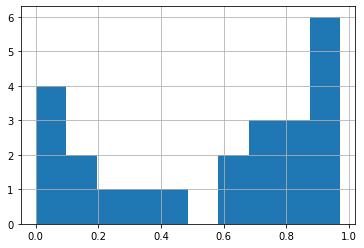

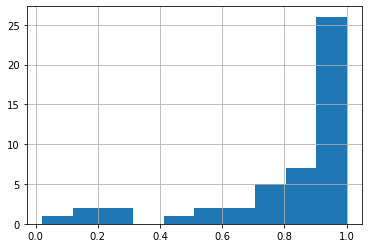

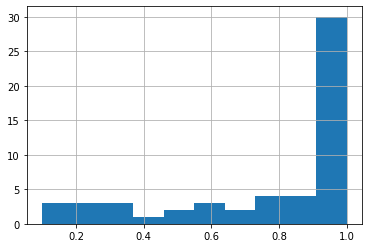

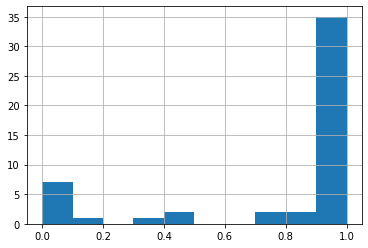

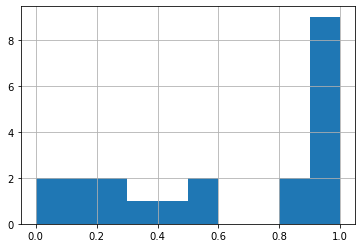

In [191]:
for n1, n2 in df_networks[_idx_model].iloc[:, :2].values:
    condition = np.logical_and(estimated_progressions['from'] == n1, 
                          estimated_progressions['to'] == n2)
    estimated_progressions[condition]['percentage'].hist()
    plt.show()
    plt.close()

# Save input for TraSig

* 1. expression
* 2. estimated_clusters, estimated_progressions
* 3. cells' s real time (if unknow, then put all as 0)

In [192]:
preprocess = ""
model_name = "_ti_slingshot"
preprocess = ""
condition = ""

if preprocess != "":
    _preprocess = "_" + preprocess
else:
    _preprocess = ""

suffix = preprocess + model_name + condition

In [193]:
output_path = "trasig/input"

## 1. save hid var of the model

1. assigned path (edge)
2. assigned time / progression on the edge 

In [194]:
estimated_progressions['from'] = [i.decode('utf-8') for i in estimated_progressions['from']] 
estimated_progressions['to'] = [i.decode('utf-8') for i in estimated_progressions['to']] 
estimated_progressions['edge'] = estimated_progressions['from'] + '_' + estimated_progressions['to'] 

In [195]:
edges = np.unique(estimated_progressions['edge'])

edge2idx = {}
for i, v in enumerate(edges):
    edge2idx[v] = i

In [196]:
edge2idx

{'2_1': 0, '2_4': 1, '3_2': 2, '3_5': 3, '3_6': 4}

In [197]:
estimated_progressions['idx_edge'] = estimated_progressions['edge'].replace(edge2idx)

In [198]:
hid_var = {'cell_path': estimated_progressions['idx_edge'].values,
          'cell_time': estimated_progressions['percentage'].values,
          'cell_labels':assignment_true['milestone_id'].values} 

In [199]:
# original assignment
filename = project + _preprocess + model_name + "_it2_hid_var.pickle"

with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(hid_var, handle, protocol=pickle.HIGHEST_PROTOCOL)

###### check percent of cluster in each edge

In [200]:
estimated_progressions['label'] = assignment_true['milestone_id'].values
estimated_progressions['cluster'] = clusters_estimated

In [201]:
estimated_progressions[estimated_progressions['cluster'] == '2']['edge'].value_counts()

3_2    14
2_4    11
2_1     6
Name: edge, dtype: int64

In [203]:
for cur_edge in edges:
    print(estimated_progressions[['label', 'edge', 'cluster']].groupby(['edge', 'label']).count().loc[cur_edge])

                                  cluster
label                                    
vα14 inkt thymocyte subset: NKT0       40
vα14 inkt thymocyte subset: NKT2        8
                                  cluster
label                                    
vα14 inkt thymocyte subset: NKT1       46
vα14 inkt thymocyte subset: NKT2        9
                                  cluster
label                                    
vα14 inkt thymocyte subset: NKT0        1
vα14 inkt thymocyte subset: NKT2       22
                                   cluster
label                                     
vα14 inkt thymocyte subset: NKT0         3
vα14 inkt thymocyte subset: NKT17       42
vα14 inkt thymocyte subset: NKT2         5
                                   cluster
label                                     
vα14 inkt thymocyte subset: NKT0         1
vα14 inkt thymocyte subset: NKT17        1
vα14 inkt thymocyte subset: NKT2        19


## 2. subsetting expression data (to keep only ligand-receptors )

1. the following code only depend on expression and ligand-receptor list 

In [204]:
input_path = "trasig/test"

In [205]:
# get interaction file (list of (ligand, receptor/target))
list_type = 'ligand_receptor'

if 'target' in list_type:
    filename = list_type + '_interactions_99.95' + '.pickle'
elif 'receptor' in list_type:
    filename = list_type + '_used_in_MESSI.pickle'
else:
    filename = list_type + '_ligand_interactions.pickle'

with open(os.path.join(input_path, filename), 'rb') as handle:
    interaction_list = pickle.load(handle)
    
ligands_receptors = np.unique([i[0] for i in interaction_list] + [i[1] for i in interaction_list])

# (optional) save ligand & receptors expression & genes names separately if not saved
genes_upper = [g.upper() for g in genes]
kepted_genes = list(set(genes_upper).intersection(set(ligands_receptors)))

df = pd.DataFrame(expression)
df.columns = genes_upper
df.index = cell_ids

df_sub = df[kepted_genes]

filename = project + _preprocess + "_lr.txt"
data_file = os.path.join(output_path, filename)
df_sub.to_csv(data_file)


# save filtered interactions 
filtered_interactions = []
for i, j in interaction_list:
    if i in kepted_genes and j in kepted_genes:
        filtered_interactions.append((i, j))
 
filename = list_type + "_" + project + _preprocess + ".pickle"
with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(filtered_interactions, handle, protocol=pickle.HIGHEST_PROTOCOL)


## 3. save correspondence from time to paths

In [206]:
from scipy import stats

In [207]:
cell_ori_time = np.repeat(0, N)

In [208]:
unique_days = np.unique(cell_ori_time)
sorted_days = list(np.sort(unique_days)) 
cell_paths = np.unique(hid_var["cell_path"])

In [209]:
sampleT2path = dict.fromkeys(range(len(sorted_days)))  # USE index of sorted sampling time as key!  
for k, v in sampleT2path.items():
    sampleT2path[k] = []

In [210]:
for i, cur_path in enumerate(cell_paths):
    print("current path", cur_path)
    
    # get data corresponding to a path
    condition = hid_var["cell_path"] == cur_path
    cur_days = np.array(cell_ori_time)[condition]
    
    # get the sampling time for the majority cells 
    mode, count = stats.mode(cur_days)
    print(mode[0], round(float(count[0])/len(cur_days), 2))
    cur_sampleT = mode[0]
    
    # will use index instead of input time 
    sampleT2path[sorted_days.index(cur_sampleT)].append(cur_path)
    

current path 0
0 1.0
current path 1
0 1.0
current path 2
0 1.0
current path 3
0 1.0
current path 4
0 1.0


In [211]:
# save the dictionary
filename = 'sampling_time_per_path_' + project + suffix + '.pickle'

with open(os.path.join(output_path, filename), 'wb') as handle:
    pickle.dump(sampleT2path, handle, protocol=pickle.HIGHEST_PROTOCOL)